# Evaluate BART on NIST vs on NEIMS

a) projet 8M BARTA na testovaci sade NEIMSu, ktera nebyla pouzita pri treninku niceho
 	=> porovnat predikce na NISTU a NEIMSu (sleduj miru BIASu NEIMSu)
    
 	   - pokud vyjde srovnatelne dobre, u obou, NIST dela dobrou praci pri aproximaci a
 	 	problem je v RCX zaspineni
 	   - pokud vyjde spatne, NEIMS vytvari vlastni druh spekter, odlisny od jakekilv reality a 
	 	 jedem GARBAGE in, GARBAGE out
b) porovnej vykon standardniho 8M Barta na deriv vs. nonderiv <br>
c) porovnej vykon DERIV Barta na deriv vs. nonderiv<br>

________________________________________________________________________
### WARPLAN
- ulozit NIST20-only datafram/y a projet pipelinou na pripravu dat (s NEIMSem jako inputem)
- z pole spekter vykres preprocesovany datasety (s NISTem jako inputem)
- oevaluj a porovnej - 

In [33]:
%load_ext autoreload
%autoreload 2

In [1]:
# copied imports, maybe filter later
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from matchms.importing import load_from_msp
from spectra_process_utils import preprocess_spectra, preprocess_spectrum
from geneval_utils import evaluate_range_opt2_prob

import sys
from data_utils import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektroForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from tokenizers import Tokenizer

/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hide rdkit warnings
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

## Load NIST20only/NEIMS csv

In [4]:
!ls

Jupyter_runner_bigdata.sh		   geneval_extended_support_script.sh
README.md				   geneval_united_demo.ipynb
RLHF					   geneval_utils.py
__pycache__				   michal_repo
bart_spektro				   neims_gen_analysis.ipynb
bart_spektro_trainer.py			   neims_gen_analysis_ntbs
checkpoints				   playWithCustomBART.ipynb
compare_NIST20only_vs_NEIMS_spectra.ipynb  remove_if_u_can
core					   run_bart_train.sh
data					   spectra_process_utils.py
dataset.py				   stats.txt
env_specification			   tmp
eval_on_NIST_vs_NEIMS.ipynb		   tokenizer
explore_different_smiles_tokenizers.ipynb  train_bart.ipynb
figures					   wandb
geneval_basic.ipynb			   zia_training_stuff_30M
geneval_extended.ipynb


In [5]:
# load NIST20only/NEIMS csv
df_nist20only = pd.read_csv("./data/NIST/NIST20_only/df_all.csv")

# add the spektra from .msp files

In [6]:
df_nist20only

,Unnamed: 0,smiles,nist_id,NEIMS_spec,isder,NIST_spec,simils,matched_peaks
0,0,[HH],1,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x15545cc...,0.000000,0
1,1,[HH],2,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x1554282...,0.999887,1
2,2,B#B,14,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.234185,1
3,3,C=C,15,<matchms.Spectrum.Spectrum object at 0x15540b0...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.936429,7
4,4,C=C,16,<matchms.Spectrum.Spectrum object at 0x155415e...,False,<matchms.Spectrum.Spectrum object at 0x155425e...,0.918633,7
...,...,...,...,...,...,...,...,...
86767,86767,CCC(C)C1NC(=O)C(NC(=O)c2c3nc4c(C(=O)NC5C(=O)NC...,350633,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...,0.794157,195
86768,86768,C[Si](C)(C)OCC1OC(Oc2cc(O[Si](C)(C)C)c3c(=O)c(...,350639,<matchms.Spectrum.Spectrum object at 0x1553ffb...,True,<matchms.Spectrum.Spectrum object at 0x1554180...,0.700275,7
86769,86769,C[Si](C)(C)OCC(O[Si](C)(C)C)C(OC1OC(CO[Si](C)(...,350640,<matchms.Spectrum.Spectrum object at 0x1553ffb...,True,<matchms.Spectrum.Spectrum object at 0x1554180...,0.879429,93
86770,86770,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,350641,<matchms.Spectrum.Spectrum object at 0x1553ffb...,False,<matchms.Spectrum.Spectrum object at 0x1554180...,0.413714,57


## Turn list of spectra into dataset
needed columns: destereo_smiles, input_ids, position_ids

In [19]:
tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
tokenizer = Tokenizer.from_file(tok)

In [11]:
# load spectra from .msp file
nist20only_nist_spectra = load_from_msp("data/NIST/NIST20_only/NIST20_only_NIST.msp", metadata_harmonization=False)
nist20only_neims_spectra = load_from_msp("data/NIST/NIST20_only/NIST20_only_NEIMS.msp", metadata_harmonization=False)

In [12]:
nist20only_nist_spectra

<generator object load_from_msp at 0x14d8f8f7c040>

In [13]:
# preprocess spectra -> df that can be fed into a SpectroDataset
print("NIST")
df_nist20only_nist = preprocess_spectra(nist20only_nist_spectra, tokenizer, spectra_name="NIST_spectra")
print("##########################\nNEIMS")
df_nist20only_neims = preprocess_spectra(nist20only_neims_spectra, tokenizer, spectra_name="NEIMS_spectra")

NIST


86772it [01:17, 1117.39it/s]


0 no smiles
296 smiles too long
0 spectra corrupted
2411 spectra w/ too high mz
8879 spectra w/ too many peaks
totally 11586 issues
discarded 10243/86772 spectra 
##########################
NEIMS


0it [00:00, ?it/s]/auto/brno2/home/ahajek/Spektro/MassGenie/spectra_process_utils.py:92: RuntimeWarning: divide by zero encountered in log
  x = (np.log(intensities)/log_base).astype(int) + log_shift
86772it [01:11, 1205.44it/s]


0 no smiles
300 smiles too long
0 spectra corrupted
2638 spectra w/ too high mz
9823 spectra w/ too many peaks
totally 12761 issues
discarded 10816/86772 spectra 


In [16]:
# create SpectroDataset
nist_data = SpectroDataset(df_nist20only_nist, original=False, eval_mode=True)
neims_data = SpectroDataset(df_nist20only_neims, original=False, eval_mode=True)

In [17]:
nist_data.data

,input_ids,position_ids,attention_mask,smiles,NIST_spectra
0,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[HH],<matchms.Spectrum.Spectrum object at 0x14d8f91...
1,"[2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[HH],<matchms.Spectrum.Spectrum object at 0x14da16b...
2,"[10, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 2...","[4, 7, 6, 7, 0, 0, 2, 5, 8, 9, 8, 9, 9, 0, -1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",B#B,<matchms.Spectrum.Spectrum object at 0x14d8f91...
3,"[2, 12, 13, 14, 15, 24, 25, 26, 27, 28, 29, 30...","[0, 0, 1, 2, 0, 2, 5, 8, 9, 9, 2, 0, -1, -1, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",C=C,<matchms.Spectrum.Spectrum object at 0x14d8f8f...
4,"[12, 13, 14, 15, 24, 25, 26, 27, 28, 29, 2, 2,...","[0, 0, 2, 0, 2, 5, 8, 8, 9, 2, -1, -1, -1, -1,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...",C=C,<matchms.Spectrum.Spectrum object at 0x14d8f8f...
...,...,...,...,...,...
76524,"[41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 5...","[7, 5, 7, 5, 7, 3, 1, 0, 2, 0, 5, 1, 7, 3, 7, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COC1CC(OC2CCC3(C=O)C4CCC5(C)C(C6=CC(=O)OC6)CCC...,<matchms.Spectrum.Spectrum object at 0x14d8d80...
76525,"[43, 77, 81, 91, 97, 103, 109, 115, 127, 131, ...","[9, 6, 9, 8, 9, 6, 8, 5, 6, 7, 4, 4, 6, 7, 5, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COC(=O)C1=COC(OC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)...,<matchms.Spectrum.Spectrum object at 0x14d8d80...
76526,"[41, 42, 43, 44, 45, 50, 55, 57, 59, 60, 61, 6...","[2, 2, 7, 2, 1, 2, 2, 2, 3, 3, 1, 3, 2, 3, 3, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COC1OC(C(COC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)=O)C...,<matchms.Spectrum.Spectrum object at 0x14d8d80...
76527,"[43, 77, 79, 81, 85, 89, 91, 97, 98, 103, 109,...","[9, 5, 9, 5, 4, 5, 5, 5, 5, 5, 8, 6, 3, 3, 6, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",COC(=O)C1=COC(OC2OC(COC(C)=O)C(OC(C)=O)C(OC(C)...,<matchms.Spectrum.Spectrum object at 0x14d8d80...


## Load model 

In [29]:
# init model
global model_path
# model_path = f'./checkpoints/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
model_path = f'./checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1680000/'
model_name = ''.join(model_path.split('/')[-3])
model = BartSpektroForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# change some configs
model.config.eos_token_id = 0
model.config.bos_token_id = tokenizer.
model.config.pad_token_id = 2
model.config.decoder_start_token_id = 3
model.config.forced_eos_token_id = 0
model.config.max_length = 200
model.config.min_length = 0

## Synchronize NIST and NEIMS
Synchronize the two dataset so it contains the same datapoints in the same order (even after filtering)
- get nist and neims ids
- get all original ids
- create throw_out_of_nist ((all_ids - neims_ids) - (all_ids - nist_ids)) and throw_out_of_neims (analogically)

In [30]:
%%time
nist_data_ids = [int(row[1].NIST_spectra.metadata["id"]) for row in nist_data.data.iterrows()]
neims_data_ids = [int(row[1].NEIMS_spectra.metadata["id"]) for row in neims_data.data.iterrows()]
all_nist20only_ids = df_nist20only.nist_id.astype(int)

CPU times: user 9.34 s, sys: 55.7 ms, total: 9.39 s
Wall time: 9.39 s


In [31]:
# add nist_id column
nist_data.data["nist_ids"] = nist_data.data.NIST_spectra.apply(lambda x: int(x.metadata["id"]))
neims_data.data["nist_ids"] = neims_data.data.NEIMS_spectra.apply(lambda x: int(x.metadata["id"]))

In [32]:
# filter out "throw_out..." ids
df_nist_data_sync = nist_data.data[nist_data.data.nist_ids.isin(neims_data_ids)]
df_neims_data_sync = neims_data.data[neims_data.data.nist_ids.isin(nist_data_ids)]

nist_data_sync = SpectroDataset(df_nist_data_sync, eval_mode=True)
neims_data_sync = SpectroDataset(df_neims_data_sync, eval_mode=True)

# Evaluate

In [40]:
from geneval_utils import evaluate_range_opt2_prob

  0%|          | 0/72784 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 72784/72784 [5:50:25<00:00,  3.46it/s]   
/auto/brno2/home/ahajek/Spektro/MassGenie/geneval_utils.py:362: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(np.sum((is_sorted_by_gt_indexes - gt_sorted_by_gt_indexes)**2)/len(is_sorted_by_gt_indexes))


###### RESULTS ######
model: bart_2023-04-07-18_27_23_30Mneims
additional info: _nist20only_nist_forcedNEIMS
data range: (0, 72783)
generated for each example: 10 samples
data type: nist_data_sync
mean RMSE of prob_simil ranking compared to GT: nan
recall@1: 0.15385249505385798
recall@3: 0.42378819520773797
average smiles simil from all unique samples: 0.24849911936178282
average simles simil from the 3 best samples: 0.31042022456571383
average smiles simil from the 1 best sample: 0.34411898692593057
mean num of unique vals: 8.250412178500769



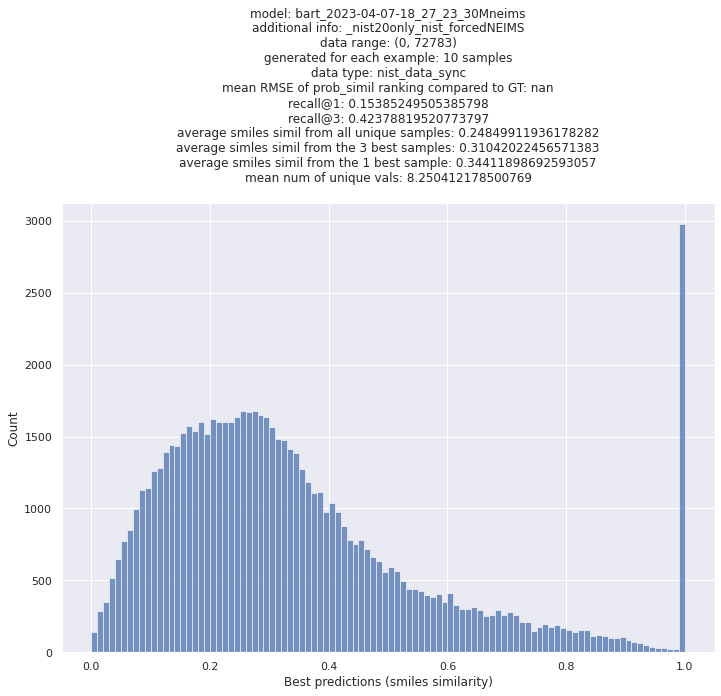

[0.001876172607879925,
 0.006349206349206349,
 0.005449591280653951,
 0.0022522522522522522,
 0.002072538860103627,
 0.002544529262086514,
 0.0033112582781456954,
 0.0021413276231263384,
 0.001771479185119575,
 0.01,
 0.015625,
 0.0023781212841854932,
 0.003787878787878788,
 0.0022624434389140274,
 0.008032128514056224,
 0.0,
 0.0,
 0.0,
 0.01948051948051948,
 0.09836065573770492,
 0.02181818181818182,
 0.011834319526627219,
 0.009345794392523364,
 0.013793103448275862,
 0.022988505747126436,
 0.017316017316017316,
 0.014492753623188406,
 0.0084985835694051,
 0.006339144215530904,
 0.0039447731755424065,
 0.05309734513274336,
 0.05128205128205128,
 0.028985507246376812,
 0.020833333333333332,
 0.021164021164021163,
 0.0,
 0.013824884792626729,
 0.016129032258064516,
 0.01073345259391771,
 0.004149377593360996,
 0.00273224043715847,
 0.012558869701726845,
 0.009271523178807948,
 0.06896551724137931,
 0.0213903743315508,
 0.13043478260869565,
 0.09401709401709402,
 0.031088082901554404,


In [78]:
# evaluate NIST
RANGE = range(0,len(df_nist_data_sync))
additional_info = "_nist20only_nist_forcedNEIMS"
source_ds = "neims" # nist, rassp, source1, source2, ...

evaluate_range_opt2_prob(model, 
                         model_name, 
                         tokenizer, 
                         nist_data_sync,
                         data_type="nist_data_sync",
                         data_range=RANGE, 
                         additional_info=additional_info, 
                         gen_kwargs = {"forced_decoder_ids": [[0] + tokenizer.encode(f"<{source_ds}>").ids]},
                         gt_list=list(df_nist_data_sync["smiles"])[min(RANGE):max(RANGE)+1], 
                         num_generated=10)

In [ ]:
# evaluate NEIMS
RANGE = range(0,len(df_nist_data_sync))
additional_info = "_nist20only_neims_ATT"
evaluate_range_opt2_prob(model, 
                         model_name, 
                         tokenizer, 
                         neims_data_sync,
                         data_type="neims_data_sync",
                         data_range=RANGE, 
                         additional_info=additional_info,
                         gen_kwargs = {"forced_decoder_ids": [[0] + tokenizer.encode(f"<{source_ds}>").ids]},
                         gt_list=list(df_neims_data_sync["smiles"])[min(RANGE):max(RANGE)+1], 
                         num_generated=10)

  0%|          | 0/72784 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
 18%|█▊        | 13338/72784 [50:12<4:25:54,  3.73it/s]

## Visualize a single prediction

In [66]:
from geneval_utils import show_predictions_for_datapoint

In [72]:
data_id=349
data=neims_data_sync
show_predictions_for_datapoint(model, tokenizer, nist_data[data_id], gt_smiles=data.data.iloc[data_id].smiles, num_generated=10, device=device)

{'top_k': None, 'top_p': 0.8, 'do_sample': True, 'num_beams': 1, 'temperature': None}


/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


AttributeError: module 'rdkit.Chem' has no attribute 'PandasTools'